# Results

## Summary

&emsp;[Validation Dataset Results](#results-with-the-validation-dataset) \
&emsp;[Analysis of the Top 3 Best Models](#analysis-of-the-best-models) \
&emsp;&emsp;[1- Simple logistic regression](#logistic-regression) \
&emsp;&emsp;[2- Logistic regression with polynomial expansion and L1](#polynomial-expansion-and-l1-logistic-regression) \
&emsp;&emsp;[3- Random Forest with log columns and "entropy" criterion](#with-log-cols-and-entropy-criterion-random-forest-classification) \
&emsp;[What about China?](#what-about-china) \
&emsp;[Answering the questions](#answering-the-questions)

## Results with the validation dataset

None, because I am doing this after the challenge, and I do not have access to the validation dataset target column to check my results against. \
A TA told me I can stick to conversion_data_train.csv because of that.

## Analysis of the best models

My top 3 best-performing models, and what conclusions they can help us come to.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

import plotly.express as px
import boto3, mlflow
import pandas as pd
import numpy as np

In [27]:
data = pd.read_csv('conversion_data_train.csv')

I could have recovered the models I wanted from MLFlow, but I did something different from last time and the artifacts don't appear in MLFlow despite having successfully been saved in the S3 bucket. This is the solution I found to not need to fit the models I want again:

In [ ]:
s3 = boto3.client("s3")

bucket_name = "conversion-rate-mlflow-artifactstore"
prefix = "1/models/"

response = s3.list_objects_v2(
    Bucket=bucket_name,
    Prefix=prefix,
    Delimiter="/"
)

folders = []
if "CommonPrefixes" in response:
    folders = [
        cp["Prefix"].removeprefix(prefix).rstrip("/")
        for cp in response["CommonPrefixes"]
    ]

print(len(folders))
print("Folders:", folders)


174
Folders: ['m-00be78b2931f4361b62cf97f44464b93', 'm-0158d4189b4f41a6b2958a5ee893cb76', 'm-02c4bfaa674b44c5853272f25886870c', 'm-0592d098b2ac48339f17f3fe2d1674f4', 'm-08fda1e736d94c72872f0b8aa3fb8588', 'm-0a243c57ba28493c811e16dd125f4ba9', 'm-0b8f6e081e9943bab77a9fbdca8fecac', 'm-0be3b608b9fe4eb4b8b1358035d73d14', 'm-0dbdc3a34c13478a9d16231b37dfdd89', 'm-0fc3b0ab5c8e4c79ae9a563089c271ab', 'm-0fef87eb59194c35b8b17e16d21b0657', 'm-0ffde8be3f8a416db2a932f8875c5d0b', 'm-10821f312d374987aec573942e587c2c', 'm-108365fa87814cb19d3247958e112b9c', 'm-118bd295aabc4221b47d600a5812bbde', 'm-162d239ce5ed42ba8af25edc56ee54aa', 'm-17f54b9a17ca4f13a7524750644d3a4f', 'm-18a3332741c849068a2c713b51eb6fd2', 'm-19c14d4d75de42dfb57d02db60d88376', 'm-1a13361e6ba545a9bea9a0b9857b2993', 'm-1aafb69e17c8496cbe59b78f36ad6dbf', 'm-1b1378d7d59a41058ca7944bd9724af4', 'm-1bccabf7982b4067861cf7287a3ba7e6', 'm-1c0c7c8a9d5749cdaabceadd1cf80d04', 'm-1c0cb61334604a6ca6baa30f20d36ecd', 'm-1d0f0452329145269e038209249ac457'

In [ ]:
for model in folders:
    model_uri = f"s3://conversion-rate-mlflow-artifactstore/1/models/{model}/artifacts/"
    loaded_model = mlflow.sklearn.load_model(model_uri)
    print("URI: " + model_uri)
    print(loaded_model, end="\n\n")

#### Logistic regression
The best of all my attempts, with an F1 score of 0.765568646309209

In [28]:
categorical_cols = ['country', 'source']
numerical_cols = ['age', 'total_pages_visited']

X = data[categorical_cols + numerical_cols + ["new_user"]] # new_user shouldn't be normalised, nor does it need to be one-hot encoded (0s and 1s already)
y = data["converted"]

X_train, X_test, _, y_test = train_test_split(
    X, y,
    train_size=0.75,
    random_state=444719,
    stratify=y
)

onehot_encoder = OneHotEncoder(drop="first", handle_unknown="ignore")
standard_scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", onehot_encoder, categorical_cols),
        ("numerical", standard_scaler, numerical_cols)
    ],
    remainder="passthrough"
)

_ = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [29]:
best_logreg_model_uri = "s3://conversion-rate-mlflow-artifactstore/1/models/m-536cb656325240ae8f4a408238b7a117/artifacts/"
best_logreg_model = mlflow.sklearn.load_model(best_logreg_model_uri)
best_logreg_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,16.95
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,444719
,solver,'lbfgs'
,max_iter,20
,multi_class,'deprecated'


In [ ]:
result = permutation_importance(best_logreg_model, X_test, y_test, n_repeats=30, random_state=444719)

imp_df = pd.DataFrame({"Feature": preprocessor.get_feature_names_out(), "Importance": result.importances_mean})
imp_df = imp_df.sort_values("Importance", ascending=False)

fig = px.bar(data_frame=imp_df, x="Feature", y="Importance", title="Permutation importance")
fig.show()

Since we used `drop="first"` in the One-Hot encoder, we are missing two features in the feature importance plot. Let's merge the features into the original columns so that the missing values don't matter as much:

In [31]:
def get_orig_col_name(col_name):
    split_name = col_name.split("_")
    if split_name[0] == "categorical":
        return "".join(split_name[2])
    else:
        return "_".join(split_name[2:])

imp_df["Original_col_names"] = imp_df["Feature"].apply(get_orig_col_name)
orig_cols_imp = imp_df.groupby("Original_col_names")["Importance"].sum().sort_values(ascending=False)
orig_cols_imp

Original_col_names
total_pages_visited    0.035798
country                0.017394
new_user               0.003266
age                    0.001357
source                 0.000051
Name: Importance, dtype: float64

In [32]:
fig = px.bar(data_frame=orig_cols_imp)
fig.show()

Using SHAP to see how much each feature increases the magnitude of the model output seems to corroborate what we saw earlier. \
Meaning of the plot: For each observation in the data, we look at the (positive or negative) impact of each of the features on the predicted result for that observation (SHAP). The size of each bar is the mean of the absolute values of those impacts across the fitted data. \
The default plot type here is a bee swarm plot, which has a lot more information but that I find very hard to read. This bar plot is much clearer: big bar 👉🏻 big impact on predictions.

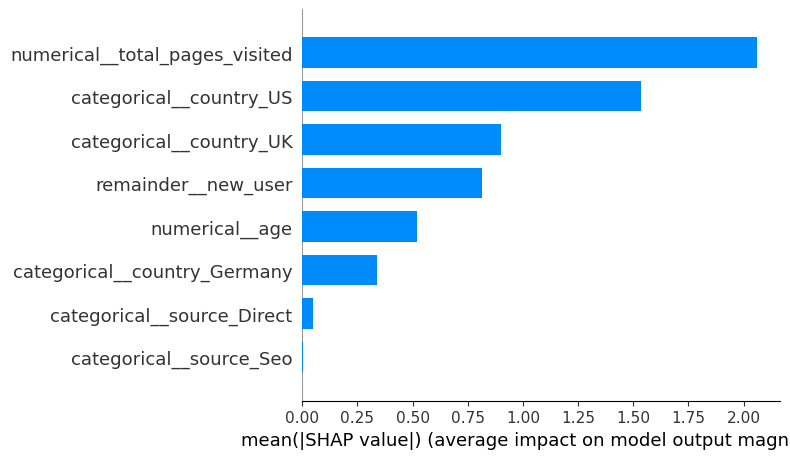

In [43]:
import shap

explainer = shap.Explainer(best_logreg_model, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=preprocessor.get_feature_names_out(), plot_type="bar")

#### Polynomial expansion and L1: Logistic regression
The second best of all my attempts, with an F1 score of 0.7596899224806202 \
Interestingly, I had to force it to use L1 to get this score. L1 was consistently weeded out by GridSearchCV when given the option. \
Polynomial expansion is a built-in way to engineer non-linear features in Sci-Kit Learn.

In [44]:
poly_l1_logreg_model_uri = "s3://conversion-rate-mlflow-artifactstore/1/models/m-02c4bfaa674b44c5853272f25886870c/artifacts/"
poly_l1_logreg_model = mlflow.sklearn.load_model(poly_l1_logreg_model_uri)
poly_l1_logreg_model

,penalty,'l1'
,dual,False
,tol,0.0001
,C,5.125
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,444719
,solver,'liblinear'
,max_iter,134560
,multi_class,'deprecated'


In [49]:
categorical_cols = ['country', 'source']
numerical_cols = ['age', 'total_pages_visited']

X = data[categorical_cols + numerical_cols + ["new_user"]] # new_user shouldn't be normalised, nor does it need to be one-hot encoded (0s and 1s already)
y = data["converted"]

X_train, X_test, _, y_test = train_test_split(
    X, y,
    train_size=0.75,
    random_state=444719,
    stratify=y
)

onehot_encoder = OneHotEncoder(drop="first", handle_unknown="ignore")
standard_scaler = StandardScaler()
poly = PolynomialFeatures(degree=3, include_bias=False)

poly_preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", onehot_encoder, categorical_cols),
        ("numerical_sc", standard_scaler, numerical_cols),
        ("numerical_poly", poly, numerical_cols)
    ],
    remainder="passthrough"
)

_ = poly_preprocessor.fit_transform(X_train)
poly_X_test = poly_preprocessor.transform(X_test)

Here, you can see what polynomial expansion does:

In [50]:
poly_preprocessor.get_feature_names_out()

array(['categorical__country_Germany', 'categorical__country_UK',
       'categorical__country_US', 'categorical__source_Direct',
       'categorical__source_Seo', 'numerical_sc__age',
       'numerical_sc__total_pages_visited', 'numerical_poly__age',
       'numerical_poly__total_pages_visited', 'numerical_poly__age^2',
       'numerical_poly__age total_pages_visited',
       'numerical_poly__total_pages_visited^2', 'numerical_poly__age^3',
       'numerical_poly__age^2 total_pages_visited',
       'numerical_poly__age total_pages_visited^2',
       'numerical_poly__total_pages_visited^3', 'remainder__new_user'],
      dtype=object)

In [52]:
result = permutation_importance(poly_l1_logreg_model, poly_X_test, y_test, n_repeats=30, random_state=444719)

poly_imp_df = pd.DataFrame({"Feature": poly_preprocessor.get_feature_names_out(), "Importance": result.importances_mean})
poly_imp_df = poly_imp_df.sort_values("Importance", ascending=False)

fig = px.bar(data_frame=poly_imp_df, x="Feature", y="Importance", title="Permutation importance")
fig.show()

In [ ]:
poly_imp_df

,Feature,Importance
6,numerical_sc__total_pages_visited,0.044452
2,categorical__country_US,0.009284
1,categorical__country_UK,0.008275
7,numerical_poly__age,0.003824
5,numerical_sc__age,0.003443
0,categorical__country_Germany,0.003210
16,remainder__new_user,0.003142
9,numerical_poly__age^2,0.002817
12,numerical_poly__age^3,0.001232
8,numerical_poly__total_pages_visited,0.001031


Let's remove columns with a permutation importance below 0.001: The values are negligble, and it makes merging them into original feature columns easier

In [ ]:
orig_poly_cols_imp_df = poly_imp_df.copy()[:10]

def get_orig_poly_col_name(col_name):
    split_name = col_name.split("_")
    if split_name[0] == "categorical":
        return "".join(split_name[2])
    elif split_name[1] in ["poly", "sc"]:
        orig_col = "_".join(split_name[3:]) # Join on "_" for consistency, and in case you want to put back the other columns
        if col_name[-2] == "^":
            orig_col = orig_col.split("^")[0]
        return orig_col
    else:
        return "_".join(split_name[2:])

orig_poly_cols_imp_df["Original_col_names"] = orig_poly_cols_imp_df["Feature"].apply(get_orig_poly_col_name)
orig_poly_cols_imp_df = orig_poly_cols_imp_df.groupby("Original_col_names")["Importance"].sum().sort_values(ascending=False)
orig_poly_cols_imp_df

Original_col_names
total_pages_visited    0.045483
country                0.020769
age                    0.011316
new_user               0.003142
Name: Importance, dtype: float64

In [72]:
fig = px.bar(data_frame=orig_poly_cols_imp_df)
fig.show()

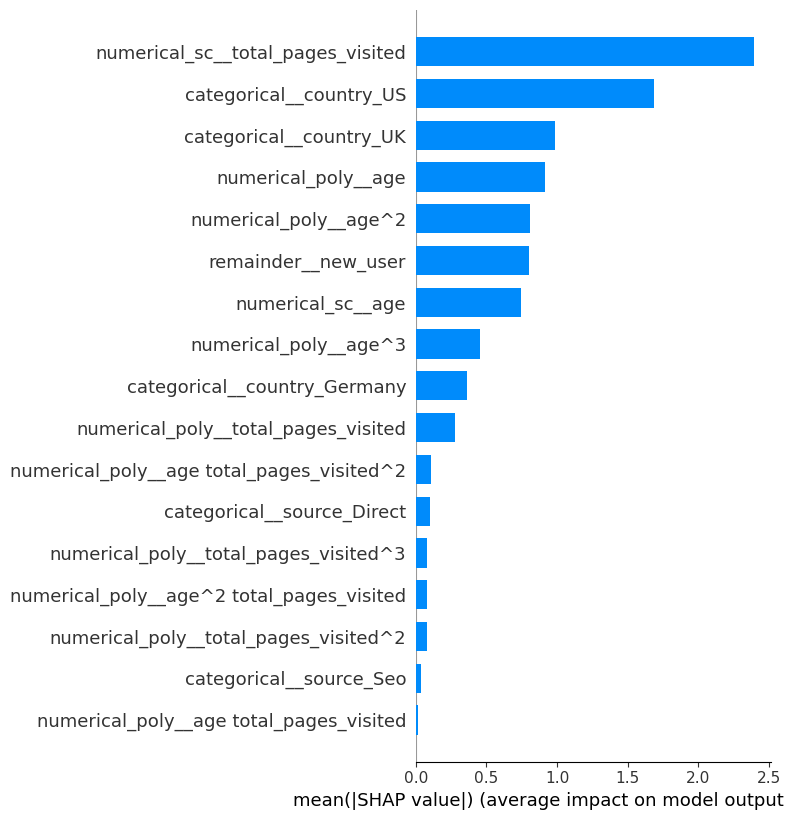

In [73]:
import shap

explainer = shap.Explainer(poly_l1_logreg_model, poly_X_test)
shap_values = explainer(poly_X_test)

shap.summary_plot(shap_values, poly_X_test, feature_names=poly_preprocessor.get_feature_names_out(), plot_type="bar")

#### With log cols and "entropy" criterion: Random forest classification
The third best of all my attempts, with an F1 score of 0.7544328394461987 \
This is one of the models that took me the longest to produce and it didn't get nearly as many rounds of GridSearchCV as others did because of how long it took to run it. This means that it may be possible to let it improve further, especially given more time and/or more compute.

In [74]:
best_randomforest_model_uri = "s3://conversion-rate-mlflow-artifactstore/1/models/m-48ca1e3753f04712b46c34040ea1cf9c/artifacts/"
best_randomforest_model = mlflow.sklearn.load_model(best_randomforest_model_uri)
best_randomforest_model

,n_estimators,1000
,criterion,'entropy'
,max_depth,50
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [89]:
categorical_cols = ['country', 'source']
numerical_cols = ['age', 'total_pages_visited']

log_data = data.copy()

log_numerical_cols = numerical_cols.copy()

for col in numerical_cols:
    log_col_name = "log_" + col
    log_data[log_col_name] = log_data[col].apply(lambda i: np.log(i+0.1 if ((i == 0) or (abs(i) == 1)) else i))
    log_numerical_cols.append(log_col_name)

X = log_data[categorical_cols + log_numerical_cols + ["new_user"]] # new_user shouldn't be normalised, nor does it need to be one-hot encoded (0s and 1s already)
y = log_data["converted"]

X_train, randfor_X_test, _, randfor_y_test = train_test_split(X, y, train_size=0.75, random_state=444719, stratify=y)

onehot_encoder = OneHotEncoder(drop="first", handle_unknown="ignore")
standard_scaler = StandardScaler()

randfor_preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", onehot_encoder, categorical_cols),
        ("numerical", standard_scaler, numerical_cols) # I left the new log columns out of the scaler by mistake, but it worked well so I left it like that
    ],
    remainder="passthrough"
)

_ = randfor_preprocessor.fit_transform(X_train)
randfor_X_test = randfor_preprocessor.transform(randfor_X_test)

In [91]:
result = permutation_importance(best_randomforest_model, randfor_X_test, randfor_y_test, n_repeats=30, random_state=444719)

randfor_imp_df = pd.DataFrame({"Feature": randfor_preprocessor.get_feature_names_out(), "Importance": result.importances_mean})
randfor_imp_df = randfor_imp_df.sort_values("Importance", ascending=False)

fig = px.bar(data_frame=randfor_imp_df, x="Feature", y="Importance", title="Permutation importance")
fig.show()

In [90]:
randfor_preprocessor.get_feature_names_out()

array(['categorical__country_Germany', 'categorical__country_UK',
       'categorical__country_US', 'categorical__source_Direct',
       'categorical__source_Seo', 'numerical__age',
       'numerical__total_pages_visited', 'remainder__log_age',
       'remainder__log_total_pages_visited', 'remainder__new_user'],
      dtype=object)

In [92]:
def get_orig_randfor_col_name(col_name):
    split_name = col_name.split("_")
    if split_name[0] == "categorical":
        return "".join(split_name[2])
    elif split_name[2] == "log":
        return "_".join(split_name[3:])
    else:
        return "_".join(split_name[2:])

randfor_imp_df["Original_col_names"] = randfor_imp_df["Feature"].apply(get_orig_randfor_col_name)
randfor_orig_cols_imp = randfor_imp_df.groupby("Original_col_names")["Importance"].sum().sort_values(ascending=False)
randfor_orig_cols_imp

Original_col_names
total_pages_visited    0.033352
new_user               0.003117
country                0.001523
age                    0.000747
source                 0.000129
Name: Importance, dtype: float64

In [93]:
fig = px.bar(data_frame=randfor_orig_cols_imp)
fig.show()

In [98]:
randfor_preprocessor.get_feature_names_out()

array(['categorical__country_Germany', 'categorical__country_UK',
       'categorical__country_US', 'categorical__source_Direct',
       'categorical__source_Seo', 'numerical__age',
       'numerical__total_pages_visited', 'remainder__log_age',
       'remainder__log_total_pages_visited', 'remainder__new_user'],
      dtype=object)

SHAP was supposed to be a model-agnostic way to measure feature importance, but it yielded results on this model that weren't readable (no labels, two features only), and there obviously was an issue. I left it out altogether, but we can still see the permutation results.

## What about China?

In the EDA phase, we saw that in a random sample, China was strongly under-represented among converted data points:
```md
country
China        3
Germany     28
UK          72
US         193
Name: converted, dtype: int64
```
But let's have a look anyway, with the best-performing model.

In [99]:
categorical_cols = ['country', 'source']
numerical_cols = ['age', 'total_pages_visited']

X = data[categorical_cols + numerical_cols + ["new_user"]] # new_user shouldn't be normalised, nor does it need to be one-hot encoded (0s and 1s already)
y = data["converted"]

X_train, X_test, _, y_test = train_test_split(
    X, y,
    train_size=0.75,
    random_state=444719,
    stratify=y
)

onehot_encoder = OneHotEncoder(handle_unknown="ignore", drop=["Germany", "Seo"]) # Drop "Germany" and "Seo" to make sure that 1) the number of features stays the same, and 2) China isn't dropped
standard_scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", onehot_encoder, categorical_cols),
        ("numerical", standard_scaler, numerical_cols)
    ],
    remainder="passthrough"
)

_ = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [100]:
best_logreg_model_uri = "s3://conversion-rate-mlflow-artifactstore/1/models/m-536cb656325240ae8f4a408238b7a117/artifacts/"
best_logreg_model = mlflow.sklearn.load_model(best_logreg_model_uri)
best_logreg_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,16.95
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,444719
,solver,'lbfgs'
,max_iter,20
,multi_class,'deprecated'


In [101]:
result = permutation_importance(best_logreg_model, X_test, y_test, n_repeats=30, random_state=444719)

imp_df = pd.DataFrame({"Feature": preprocessor.get_feature_names_out(), "Importance": result.importances_mean})
imp_df = imp_df.sort_values("Importance", ascending=False)

fig = px.bar(data_frame=imp_df, x="Feature", y="Importance", title="Permutation importance")
fig.show()

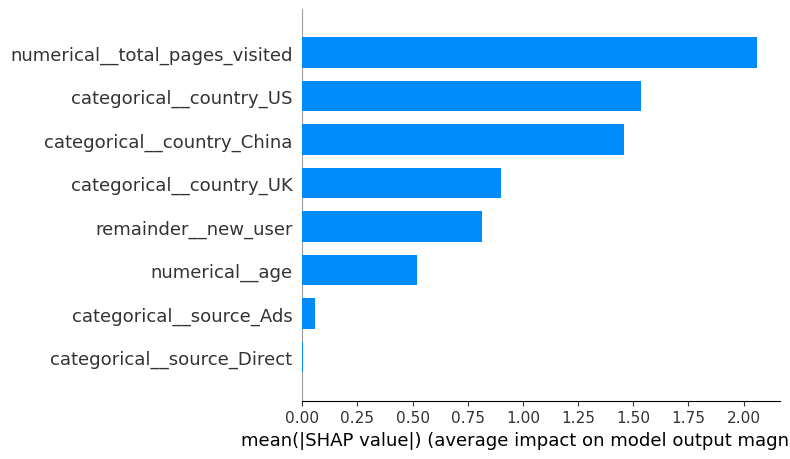

In [102]:
import shap

explainer = shap.Explainer(best_logreg_model, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=preprocessor.get_feature_names_out(), plot_type="bar")

## Answering the questions

#### Are there any levers for action that would help to improve the newsletter's conversion rate? What recommendations would you make to the team?

In no particular order, the factors with the biggest impact on whether a user goes ahead and subscribes to the newsletter are:
1. The number of pages of the website the user has visited;
2. Whether a user is from the US/UK/China;
3. Whether the user is new.

In order to increase their subscriber numbers, the team should look into getting new users from the US, the UK, and China, and making sure they spend time browsing through the website to discover what it has to offer.